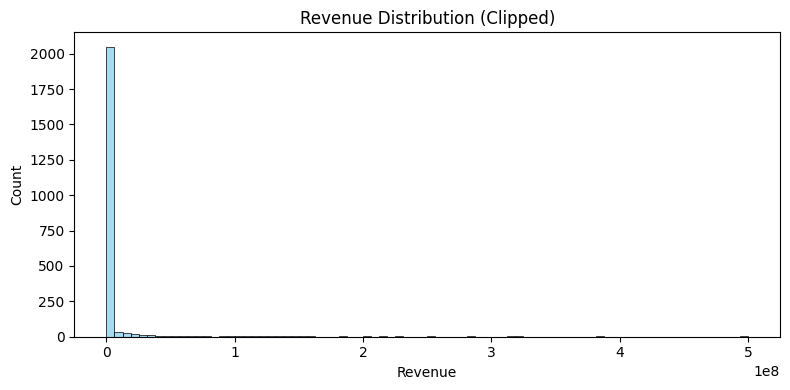

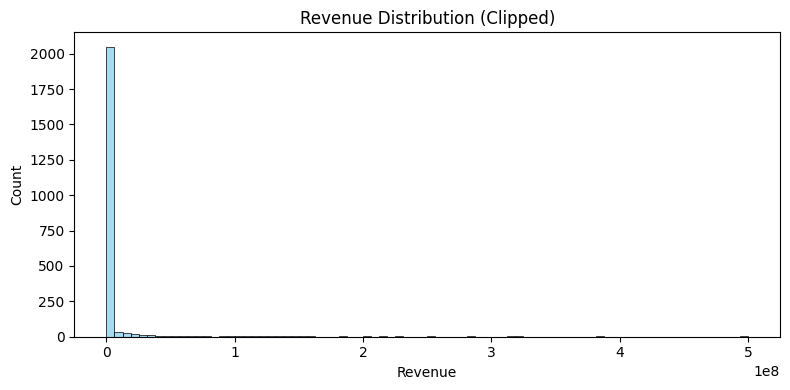

In [2]:
import tkinter as tk
from tkinter import ttk, messagebox
import pandas as pd
import numpy as np
import ast
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# --- Data Preparation ---
def parse_genres(genres_str):
    if pd.isna(genres_str):
        return []
    try:
        parsed = ast.literal_eval(genres_str)
        return [g.get("name","") for g in parsed] if isinstance(parsed,list) else []
    except:
        return []

def prepare_features(df):
    df['budget'] = pd.to_numeric(df['budget'], errors='coerce')
    df['revenue'] = pd.to_numeric(df['revenue'], errors='coerce')
    df['runtime'] = pd.to_numeric(df['runtime'], errors='coerce')
    df['popularity'] = pd.to_numeric(df['popularity'], errors='coerce')
    df['vote_average'] = pd.to_numeric(df['vote_average'], errors='coerce')
    df['vote_count'] = pd.to_numeric(df['vote_count'], errors='coerce')
    df = df.dropna(subset=['revenue','budget','popularity'])
    df['genres_list'] = df['genres'].apply(parse_genres)
    
    all_genres = df['genres_list'].explode().value_counts()
    top_genres = all_genres.head(12).index.tolist()
    
    for g in top_genres:
        df[f'genre_{g}'] = df['genres_list'].apply(lambda lst: int(g in lst))
    
    df['cast_count'] = 0
    df['log_budget'] = np.log1p(df['budget'])
    df['log_popularity'] = np.log1p(df['popularity'])
    df['log_vote_count'] = np.log1p(df['vote_count'])
    
    features = ['log_budget','runtime','popularity','vote_average','vote_count','cast_count'] + [f'genre_{g}' for g in top_genres]
    df[features] = df[features].fillna(0)
    
    return df, features, top_genres

# --- Load data (sample for speed) ---
df_movies = pd.read_csv("movies_metadata.csv", low_memory=False).sample(frac=0.05, random_state=42)
df_movies, feature_list, top_genres = prepare_features(df_movies)

X = df_movies[feature_list]
y = np.log1p(df_movies['revenue'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Decision Tree to prevent overfitting
model = DecisionTreeRegressor(max_depth=8, min_samples_split=10, min_samples_leaf=5, random_state=42)
model.fit(X_train, y_train)
median_rev = df_movies['revenue'].median()

# --- GUI Functions ---
def show_stats():
    stats_win = tk.Toplevel(root)
    stats_win.title("Training Data Statistics")
    stats_win.geometry("700x500")
    
    stats_text = tk.Text(stats_win, wrap='word')
    stats_text.pack(expand=True, fill='both', padx=10, pady=10)
    
    stats_text.insert(tk.END, "Top 10 Movies by Revenue:\n")
    stats_text.insert(tk.END, df_movies[['title','revenue']].sort_values('revenue',ascending=False).head(10).to_string())
    stats_text.insert(tk.END, "\n\nSummary Statistics:\n")
    stats_text.insert(tk.END, df_movies[['budget','revenue','runtime','popularity','vote_average','vote_count']].describe().to_string())
    
    corr = df_movies[['revenue','budget','runtime','popularity','vote_average','vote_count','cast_count']].corr()['revenue']
    stats_text.insert(tk.END, "\n\nCorrelation with revenue:\n")
    stats_text.insert(tk.END, corr.to_string())
    
    # Plot histogram
    plt.figure(figsize=(8,4))
    sns.histplot(df_movies['revenue'].clip(upper=5e8), bins=80, kde=False, color='skyblue')
    plt.title("Revenue Distribution (Clipped)")
    plt.xlabel("Revenue")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

def predict_movie():
    try:
        budget = float(entry_budget.get())
        runtime = float(entry_runtime.get())
        popularity = float(entry_popularity.get())
        vote_avg = float(entry_voteavg.get())
        vote_count = float(entry_votecount.get())
        cast_count = float(entry_cast.get())
        genres_sel = [top_genres[i] for i, var in enumerate(genres_vars) if var.get()]
        
        fv = {
            'log_budget': np.log1p(budget),
            'runtime': runtime,
            'popularity': popularity,
            'vote_average': vote_avg,
            'vote_count': vote_count,
            'cast_count': cast_count
        }
        for g in top_genres:
            fv[f'genre_{g}'] = int(g in genres_sel)
        
        X_new = pd.DataFrame([fv], columns=feature_list)
        pred_log = model.predict(X_new)[0]
        pred_rev = np.expm1(pred_log)
        
        result_label.config(text=f"Predicted Revenue: ${pred_rev:,.0f}")
        success = "SUCCESS" if pred_rev > median_rev else "NOT SUCCESSFUL"
        success_label.config(text=f"Prediction: {success} (Threshold: ${median_rev:,.0f})")
    except Exception as e:
        messagebox.showerror("Error", str(e))

# --- Tkinter GUI Layout ---
root = tk.Tk()
root.title("🎬 Movie Box Office Predictor")
root.geometry("600x650")
root.resizable(False, False)

# Header
header = ttk.Label(root, text="Movie Box Office Predictor", font=("Helvetica", 18, "bold"))
header.pack(pady=10)

# Buttons
frame_buttons = tk.Frame(root)
frame_buttons.pack(pady=5)
ttk.Button(frame_buttons, text="1. Show Training Stats", command=show_stats).pack(side=tk.LEFT, padx=10)
ttk.Label(frame_buttons, text="2. Predict New Movie", font=("Helvetica", 12, "bold")).pack(side=tk.LEFT, padx=10)

# Form Frame
frame_form = tk.Frame(root)
frame_form.pack(pady=10, padx=10, fill='x')

labels = ["Budget (USD)", "Runtime (min)", "Popularity", "Vote Average", "Vote Count", "Cast Count"]
entries = []
for i, label in enumerate(labels):
    ttk.Label(frame_form, text=label+":").grid(row=i, column=0, sticky=tk.W, pady=3)
    entry = ttk.Entry(frame_form, width=20); entry.grid(row=i, column=1, pady=3)
    entries.append(entry)
entry_budget, entry_runtime, entry_popularity, entry_voteavg, entry_votecount, entry_cast = entries

ttk.Label(frame_form, text="Select Genres:").grid(row=6, column=0, sticky=tk.W, pady=3, columnspan=2)
genres_vars = [tk.BooleanVar() for _ in top_genres]
for i, g in enumerate(top_genres):
    ttk.Checkbutton(frame_form, text=g, variable=genres_vars[i]).grid(row=7+i//4, column=i%4, sticky=tk.W)

# Predict Button and Output
ttk.Button(root, text="Predict", command=predict_movie).pack(pady=15)
result_label = ttk.Label(root, text="Predicted Revenue: $0", font=("Helvetica", 12))
result_label.pack(pady=3)
success_label = ttk.Label(root, text="Prediction: ---", font=("Helvetica", 12, "bold"))
success_label.pack(pady=3)

root.mainloop()
